In [ ]:
# Rangga Yoga Pratama
# PBD 4

# Import Library

In [33]:
! pip install --upgrade xgboost==3.0.2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Project Data mining/Dataset/data_balita.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [6]:
data.head(5)

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


In [7]:
data.tail(5)

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
120994,60,perempuan,100.6,normal
120995,60,perempuan,98.3,stunted
120996,60,perempuan,121.3,normal
120997,60,perempuan,112.2,normal
120998,60,perempuan,109.8,normal


In [ ]:
# Melihat Tendensi Sentral & Sebaran Data

In [8]:
data.describe()

,Umur (bulan),Tinggi Badan (cm)
count,120999.000000,120999.000000
mean,30.173803,88.655434
std,17.575119,17.300997
min,0.000000,40.010437
25%,15.000000,77.000000
50%,30.000000,89.800000
75%,45.000000,101.200000
max,60.000000,128.000000


In [ ]:
# Melihat Missing Value

In [9]:
data.isnull().sum()

,0
Umur (bulan),0
Jenis Kelamin,0
Tinggi Badan (cm),0
Status Gizi,0


In [10]:
#melihat data jumlah data unik di setiap atribut
data.nunique()

,0
Umur (bulan),61
Jenis Kelamin,2
Tinggi Badan (cm),6800
Status Gizi,4


In [11]:
# Fungsi untuk mendeteksi outlier
def detect_outliers_iqr(data, columns):
    outlier_info = {}
    for col in columns:
        if np.issubdtype(data[col].dtype, np.number):
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
            outlier_info[col] = len(outliers)
    return outlier_info

# Pilih kolom numerik
numeric_cols = data.select_dtypes(include=np.number).columns.tolist()

# Deteksi outlier
outlier_counts = detect_outliers_iqr(data, numeric_cols)

# Tampilkan hasil
for col, count in outlier_counts.items():
    print(f"Kolom '{col}' memiliki {count} outlier")


Kolom 'Umur (bulan)' memiliki 0 outlier
Kolom 'Tinggi Badan (cm)' memiliki 38 outlier


In [12]:
# Smoting pake clip
def clip_outliers(data, columns):
    for col in columns:
        if np.issubdtype(data[col].dtype, np.number):
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data[col] = np.clip(data[col], lower_bound, upper_bound)
    return data

# Gunakan fungsi
data_clipped = clip_outliers(data.copy(), numeric_cols)

# Cek hasil
print(data_clipped.head())


   Umur (bulan) Jenis Kelamin  Tinggi Badan (cm)       Status Gizi
0             0     laki-laki          44.591973           stunted
1             0     laki-laki          56.705203            tinggi
2             0     laki-laki          46.863358            normal
3             0     laki-laki          47.508026            normal
4             0     laki-laki          42.743494  severely stunted


In [13]:
# Mapping kategori ke nilai numerik
gender_map = {'laki-laki': 0, 'perempuan': 1}
status_map = {'severely stunted': 0,'stunted': 1,'normal': 2,'tinggi': 3}
# Terapkan mapping
data['Jenis Kelamin'] = data['Jenis Kelamin'].map(gender_map)
data['Status Gizi'] = data['Status Gizi'].map(status_map)

# Tampilkan hasil setelah konversi
data.head()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,0,44.591973,1
1,0,0,56.705203,3
2,0,0,46.863358,2
3,0,0,47.508026,2
4,0,0,42.743494,0


In [14]:
duplikat = data[data.duplicated()]
print("Data duplikat berdasarkan semua kolom:")
print(duplikat)


Data duplikat berdasarkan semua kolom:
        Umur (bulan)  Jenis Kelamin  Tinggi Badan (cm)  Status Gizi
6012               3              0               62.1            2
6014               3              0               59.2            2
6027               3              0               61.4            2
6031               3              0               71.0            3
6032               3              0               51.5            0
...              ...            ...                ...          ...
120994            60              1              100.6            2
120995            60              1               98.3            1
120996            60              1              121.3            2
120997            60              1              112.2            2
120998            60              1              109.8            2

[81574 rows x 4 columns]


In [15]:
# Menghapus semua duplikat berdasarkan seluruh kolom
data_bersih = data.drop_duplicates()

print(data_bersih)

        Umur (bulan)  Jenis Kelamin  Tinggi Badan (cm)  Status Gizi
0                  0              0          44.591973            1
1                  0              0          56.705203            3
2                  0              0          46.863358            2
3                  0              0          47.508026            2
4                  0              0          42.743494            0
...              ...            ...                ...          ...
120959            60              1         100.700000            2
120967            60              1         113.700000            2
120968            60              1         107.500000            2
120972            60              1         127.600000            3
120993            60              1         116.100000            2

[39425 rows x 4 columns]


# Kesalahan data_bersih

In [16]:
# Menampilkan jumlah baris setelah dihapus
print("Jumlah data setelah menghapus duplikat:", data_bersih.shape[0])

Jumlah data setelah menghapus duplikat: 39425


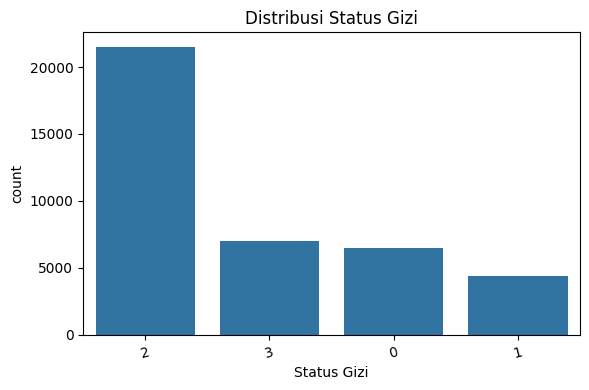

In [17]:
# Visualisasi Distribusi Status Gizi
plt.figure(figsize=(6, 4))
sns.countplot(data=data_bersih, x='Status Gizi', order=data_bersih['Status Gizi'].value_counts().index)
plt.title("Distribusi Status Gizi")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


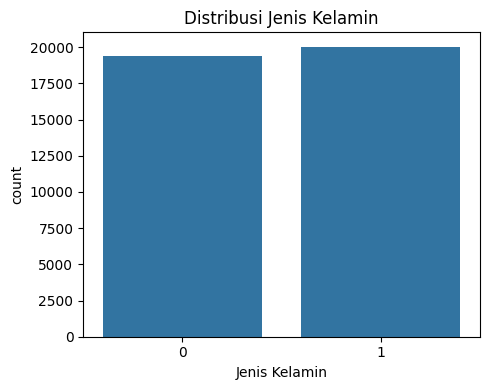

In [19]:
# Distribusi Jenis Kelamin
plt.figure(figsize=(5, 4))
sns.countplot(data=data_bersih, x='Jenis Kelamin')
plt.title("Distribusi Jenis Kelamin")
plt.tight_layout()
plt.show()

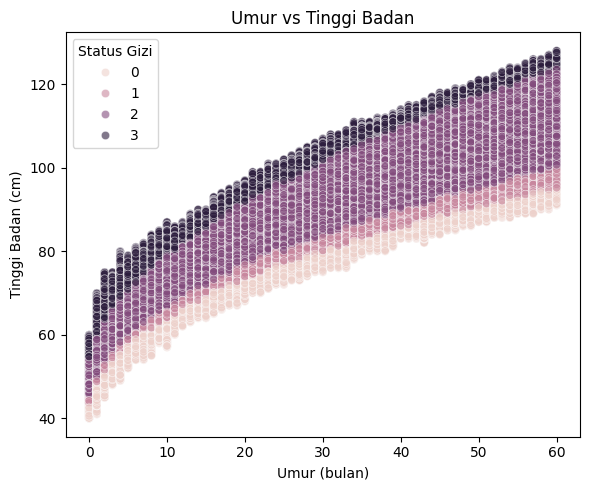

In [20]:
# Scatterplot Umur vs Tinggi Badan
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data_bersih, x='Umur (bulan)', y='Tinggi Badan (cm)', hue='Status Gizi', alpha=0.6)
plt.title("Umur vs Tinggi Badan")
plt.tight_layout()
plt.show()

In [21]:
# --- Fitur Extraction ---
# Buat fitur baru: tinggi dibanding rata-rata
tinggi_mean = data_bersih['Tinggi Badan (cm)'].mean()
data_bersih['Tinggi di atas rata-rata'] = (data_bersih['Tinggi Badan (cm)'] > tinggi_mean).astype(int)


# Lihat hasil
print(data.head())

   Umur (bulan)  Jenis Kelamin  Tinggi Badan (cm)  Status Gizi
0             0              0          44.591973            1
1             0              0          56.705203            3
2             0              0          46.863358            2
3             0              0          47.508026            2
4             0              0          42.743494            0


<ipython-input-21-1527045029>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bersih['Tinggi di atas rata-rata'] = (data_bersih['Tinggi Badan (cm)'] > tinggi_mean).astype(int)


<ipython-input-22-1672846040>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Tinggi di atas rata-rata', data=data_bersih, palette='viridis')


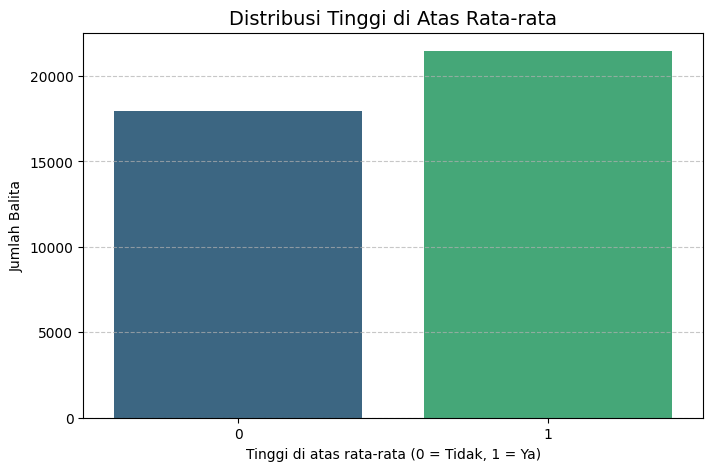

In [22]:
# Visualisasi distribusi fitur baru
plt.figure(figsize=(8,5))
sns.countplot(x='Tinggi di atas rata-rata', data=data_bersih, palette='viridis')
plt.title('Distribusi Tinggi di Atas Rata-rata', fontsize=14)
plt.xlabel('Tinggi di atas rata-rata (0 = Tidak, 1 = Ya)')
plt.ylabel('Jumlah Balita')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [23]:
# Pisahkan fitur (X) dan target (y)
X = data_bersih.drop(columns=['Status Gizi'])
y = data_bersih['Status Gizi']


# Lakukan seleksi fitur dengan ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')
X_selected = selector.fit_transform(X, y)

# Buat DataFrame untuk menampilkan skor tiap fitur
feature_scores = pd.DataFrame({
    'Fitur': X.columns,
    'Skor ANOVA F-test': selector.scores_
}).sort_values(by='Skor ANOVA F-test', ascending=False)

# Tampilkan hasil
print("Skor Seleksi Fitur:")
print(feature_scores)

Skor Seleksi Fitur:
                      Fitur  Skor ANOVA F-test
2         Tinggi Badan (cm)        2314.768315
3  Tinggi di atas rata-rata        1656.860023
0              Umur (bulan)         779.296715
1             Jenis Kelamin           7.482395


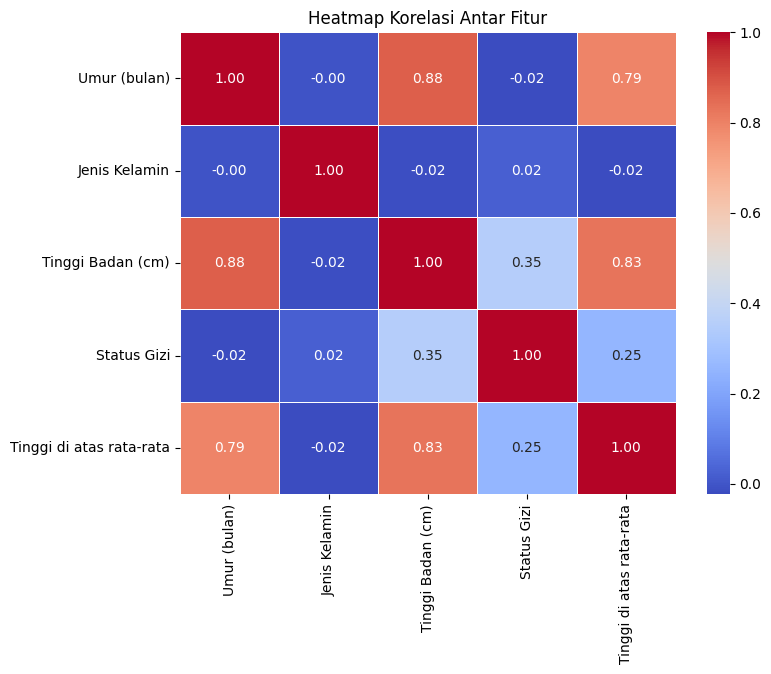

In [24]:
# Menghitung korelasi antar fitur
correlation_matrix = data_bersih.corr(numeric_only=True)
# Visualisasi heatmap korelasi
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

In [ ]:
# Modeling

In [25]:
X = data_bersih.drop(columns=['Status Gizi'])
y = data_bersih['Status Gizi']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print("Total data:", len(X_selected))


Total data: 39425


In [28]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:31:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
y_pred = xgb_model.predict(X_test)
print("=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred))

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1330
           1       0.95      0.96      0.96       838
           2       0.99      0.99      0.99      4339
           3       0.98      0.98      0.98      1378

    accuracy                           0.98      7885
   macro avg       0.98      0.98      0.98      7885
weighted avg       0.98      0.98      0.98      7885



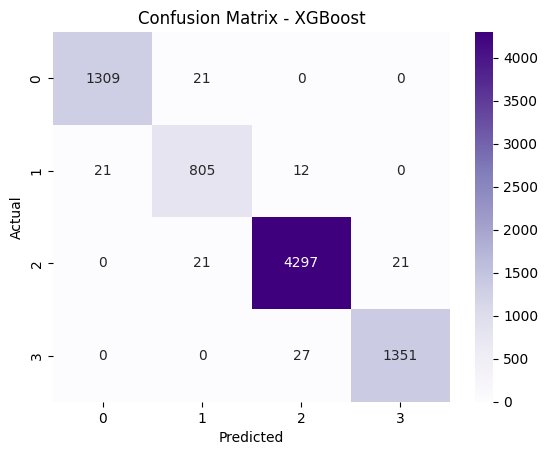

In [30]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [31]:
import joblib
joblib.dump(xgb_model, "model_xgboost1.pkl")

['model_xgboost1.pkl']

In [32]:
# 1. Simpan nilai rata-rata tinggi badan (untuk fitur tambahan)
tinggi_mean = data_bersih['Tinggi Badan (cm)'].mean()
joblib.dump(tinggi_mean, 'tinggi_mean.pkl')

# 2. Simpan daftar fitur yang digunakan (penting untuk prediksi)
X = data_bersih.drop(columns=['Status Gizi'])  # X final yang digunakan saat training
joblib.dump(X.columns.tolist(), 'fitur_model.pkl')


['fitur_model.pkl']